# Choice Set space for Neural Data

 The idea is to create a choice set that: samples the same SV difference (+ - some variation) with different trials  

In [10]:
#Import the relevant libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
#pd.options.display.max_rows = 999
#pd.options.display.max_columns = 999

# 1. Input: 
- Patient's RAW data

- Parameters from the utility model

In [11]:

#path= 'Z:/Santiago_Guardo/data' #Specify where the data is stored in the FileShare. This is for my Laptop

#Path to the data files
path = '/Volumes/UCDN/Santiago_Guardo/data' #MAC path to the File share
patient_code = 'patient1_calibration' #Specify the patient's code
patient_split_dir = os.path.join(path,'split') 
patient_trials = os.path.join(patient_split_dir,'{}/crdm/{}_crdm.csv').format(patient_code,patient_code) #This is the psychopy output CSV

#Path to the utility model data
utility_dir = os.path.join(path,'utility')
utility_analysis = os.path.join(utility_dir,'split_CRDM_analysis.csv')
parameters = pd.read_csv(utility_analysis)

print('loading fn: {}'.format(patient_trials))
print('loading fn: {}'.format(utility_analysis))


loading fn: /Volumes/UCDN/Santiago_Guardo/data/split/patient1_calibration/crdm/patient1_calibration_crdm.csv
loading fn: /Volumes/UCDN/Santiago_Guardo/data/utility/split_CRDM_analysis.csv


In [12]:
#Declare the variables we are going to be using

trials = pd.read_csv(patient_trials)
p_options = trials['crdm_lott_p'].unique()/100
p_options = p_options[~np.isnan(p_options)]  # Remove nan values ~is a logical NOT operator
p_list = p_options.tolist()  # Do we want p_options to be an array or a list? Ask Ricardo 
p_options


array([0.5 , 0.75, 0.25, 0.13, 0.38])

In [13]:
trials

,crdm_sure_amt,crdm_sure_p,crdm_lott_top,crdm_lott_bot,crdm_lott_p,crdm_amb_lev,crdm_domain,crdm_img,crdm_win_side,crdm_pract_trials.thisRepN,...,crdm_trials_iti1_poly.stopped,crdm_delta_time,crdm_iti_time,bonus_choice,bonus_earnings,participant,date,expName,psychopyVersion,frameRate
0,5.0,100.0,40.0,0.0,50.0,74.0,gain,ambig_74.bmp,top,0.0,...,NaN,NaN,NaN,NaN,NaN,CRDM_e2,2023-08-17_15h33.12.473,CRDM_GL,2022.2.4,59.875041
1,-5.0,100.0,0.0,-8.0,75.0,0.0,loss,risk_blue_75.bmp,bottom,0.0,...,NaN,NaN,NaN,NaN,NaN,CRDM_e2,2023-08-17_15h33.12.473,CRDM_GL,2022.2.4,59.875041
2,-5.0,100.0,0.0,-40.0,75.0,0.0,loss,risk_blue_75.bmp,bottom,0.0,...,NaN,NaN,NaN,NaN,NaN,CRDM_e2,2023-08-17_15h33.12.473,CRDM_GL,2022.2.4,59.875041
3,5.0,100.0,0.0,50.0,25.0,0.0,gain,risk_blue_25.bmp,bottom,0.0,...,NaN,NaN,NaN,NaN,NaN,CRDM_e2,2023-08-17_15h33.12.473,CRDM_GL,2022.2.4,59.875041
4,-5.0,100.0,-20.0,0.0,75.0,0.0,loss,risk_red_75.bmp,top,0.0,...,NaN,NaN,NaN,NaN,NaN,CRDM_e2,2023-08-17_15h33.12.473,CRDM_GL,2022.2.4,59.875041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,-5.0,100.0,-50.0,0.0,25.0,0.0,loss,risk_red_25.bmp,top,NaN,...,1193.094999,0.998971,1.773072,NaN,NaN,CRDM_e2,2023-08-17_15h33.12.473,CRDM_GL,2022.2.4,59.875041
115,5.0,100.0,30.0,0.0,75.0,0.0,gain,risk_red_75.bmp,top,NaN,...,1203.394017,0.614252,1.750046,NaN,NaN,CRDM_e2,2023-08-17_15h33.12.473,CRDM_GL,2022.2.4,59.875041
116,-5.0,100.0,0.0,-8.0,25.0,0.0,loss,risk_blue_25.bmp,bottom,NaN,...,1213.651489,1.348838,2.514379,NaN,NaN,CRDM_e2,2023-08-17_15h33.12.473,CRDM_GL,2022.2.4,59.875041
117,-5.0,100.0,-40.0,0.0,50.0,50.0,loss,ambig_50.bmp,top,NaN,...,NaN,0.000000,1.510008,NaN,NaN,CRDM_e2,2023-08-17_15h33.12.473,CRDM_GL,2022.2.4,59.875041


# 2. Plotting raw behavior

In [14]:
#df from original trials output
df =  trials[['crdm_trial_type', 'crdm_domain','crdm_sure_amt', 'crdm_lott_bot', 'crdm_lott_top', 'crdm_lott_p', 'crdm_amb_lev', 'crdm_choice', 'crdm_choice2','crdm_lott','crdm_lott2']].copy()

#filtering out practice and Nan values
df = df.loc[df['crdm_trial_type'] != 'practice']
df = df[df['crdm_choice'].notna()]

#Adding the lotterys
df['value_reward'] = df['crdm_lott_bot'] +  df['crdm_lott_top']

#Dropping unneccesary columns
df = df.drop(columns=['crdm_trial_type','crdm_lott_bot','crdm_lott_top']).reset_index(drop=True)

#Organizing
column_order = ['crdm_sure_amt', 'crdm_domain', 'crdm_lott_p','value_reward', 'crdm_amb_lev', 'crdm_choice', 'crdm_choice2', 'crdm_lott', 'crdm_lott2']
df = df[column_order]
dfgains = df.loc[df['crdm_domain'] == 'gain']
dfloss = df.loc [df['crdm_domain'] == 'loss']



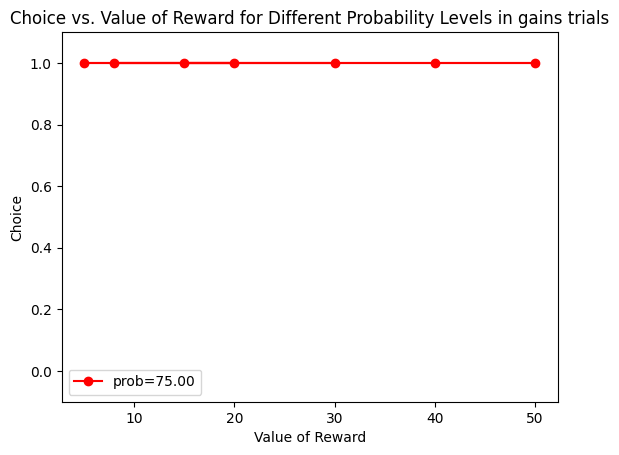

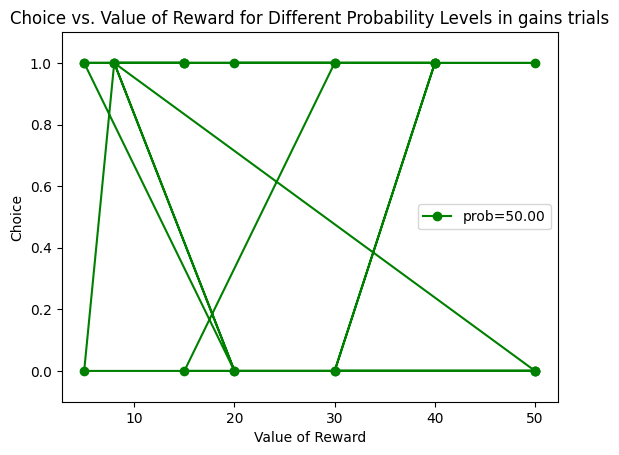

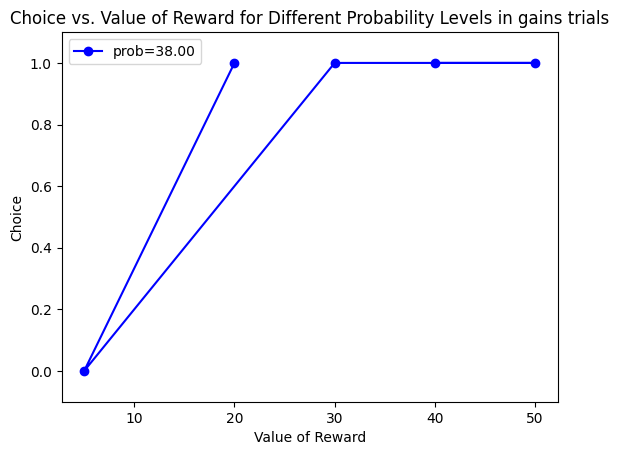

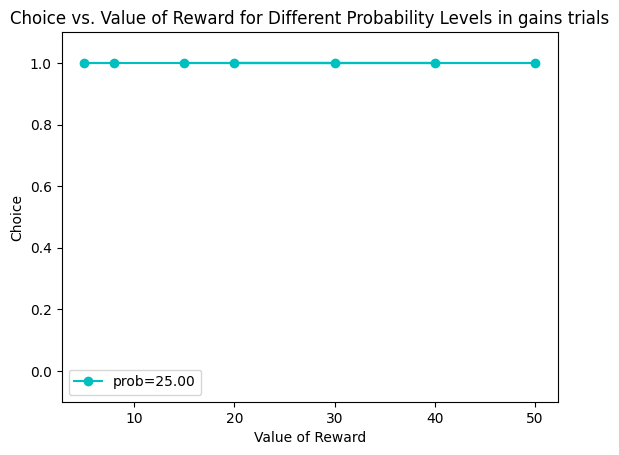

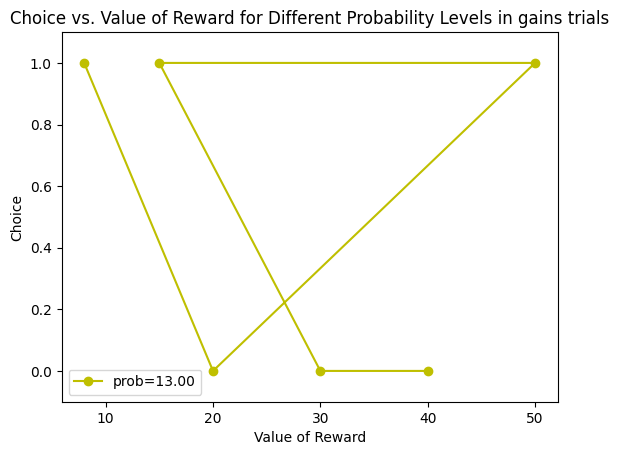

In [15]:
def plotting_raw_behavior(df, trials='gains'):
    colors = ['r', 'g', 'b', 'c', 'y', 'm', 'k']
    probs = sorted(df['crdm_lott_p'].unique(), reverse=True)

    for i, p in enumerate(probs):
        subset_df = df[df['crdm_lott_p'] == p]
        x = subset_df['value_reward']
        y = subset_df['crdm_choice']

        plt.plot(x, y, '{}o-'.format(colors[i]), label='prob={0:0.2f}'.format(p))

        plt.title('Choice vs. Value of Reward for Different Probability Levels in {} trials'.format(trials))
        plt.xlabel('Value of Reward')
        plt.ylabel('Choice')
        plt.ylim([-0.1,1.1])  # Set y-axis limits to 0 and 1
        plt.legend()
        plt.show()

plotting_raw_behavior(dfgains, trials='gains')

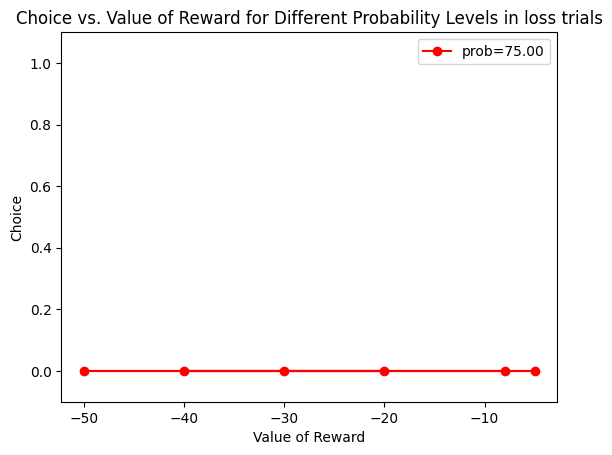

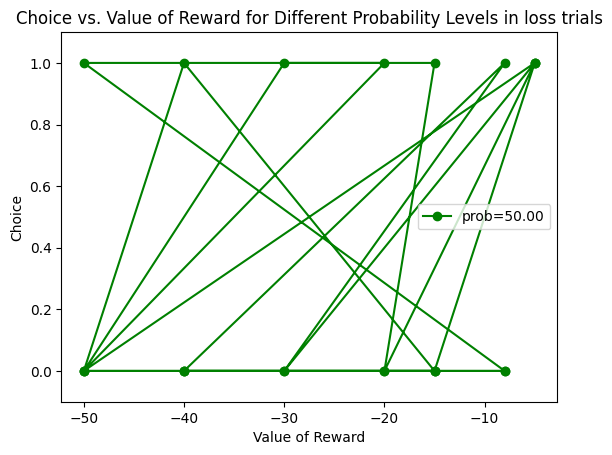

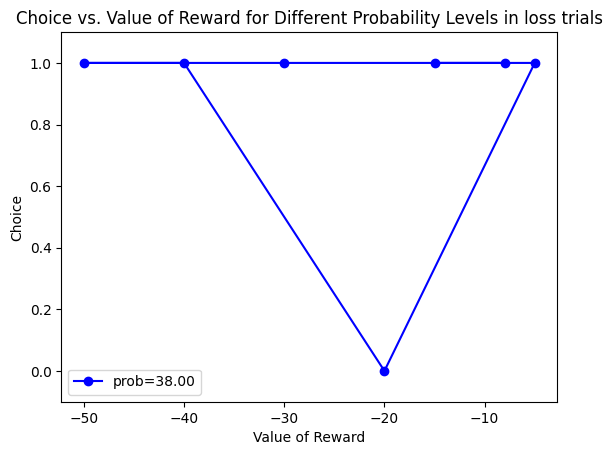

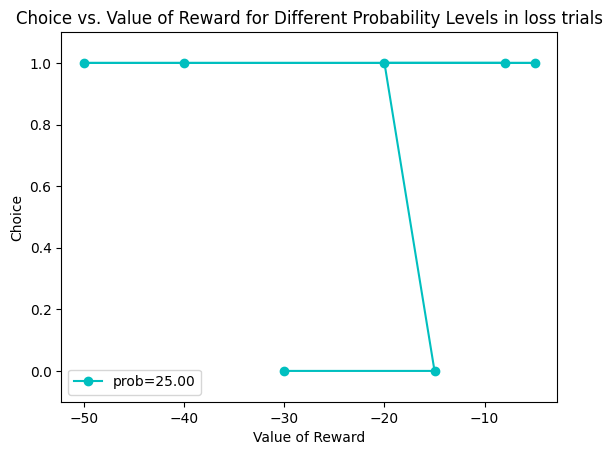

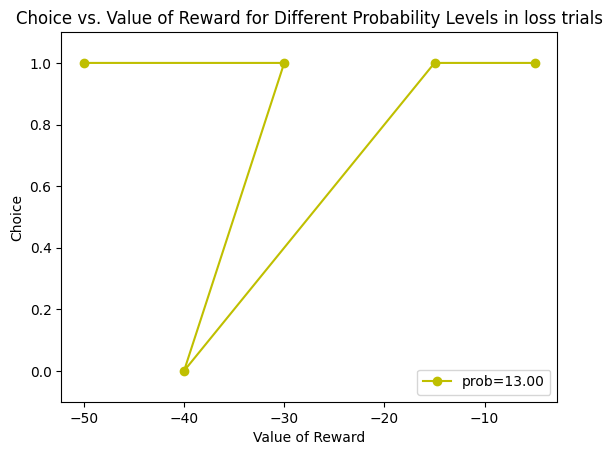

In [16]:
plotting_raw_behavior(dfloss, trials='loss')

# 3. Running the model  

In [17]:

#Define the parameter values for the given participant. 
filtered_parameters = parameters[parameters['subject'] == patient_code]

# Create alpha_pos and alpha_neg variables
alpha_pos = filtered_parameters.loc[filtered_parameters['domain'] == 'gain', 'alpha'].values[0]
alpha_neg = filtered_parameters.loc[filtered_parameters['domain'] == 'loss', 'alpha'].values[0]

beta_pos = filtered_parameters.loc[filtered_parameters['domain'] == 'gain', 'beta'].values[0]
beta_neg = filtered_parameters.loc[filtered_parameters['domain'] == 'loss', 'beta'].values[0]

print("alpha_pos:", alpha_pos)
print("alpha_neg:", alpha_neg)

print("beta_pos:", beta_pos)
print("beta_pos:", beta_neg)



alpha_pos: 0.1286154715090123
alpha_neg: 0.415047662498603
beta_pos: -0.3918035142034978
beta_pos: 4.167
